In [1]:
import sys; sys.path.append('../')

import time

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# Try to binarize

In [3]:
clusters, _ = load_data('../data/huge_sample_input_classified.txt')

In [4]:
clusters['classification'] = (
    ((clusters['classification'] == 'Candidate') | (clusters['classification'] == 'Spread'))
)

In [5]:
train_percentage = 0.8

data = clusters.replace('None', np.nan).dropna(axis=1)\
    .drop([
        'file_origin', 'file_destination', 'confidence',
        'texture_code_origin', 'texture_code_destination'
    ], axis=1)

X = data.drop('classification', axis=1)
X = (X - X.mean()) / X.std()
y = data['classification']

train_indexes, test_indexes = next(StratifiedShuffleSplit(n_splits=1, train_size=0.8).split(X, y))
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, RadiusNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, SVC
]

In [7]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                                f1_score, roc_auc_score, classification_report)

results = {m.__name__: {} for m in models}
for Model in models:
    t_start = time.time()    
    try:
        model = Model()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - t_start
        y_pred = model.predict(X_test)
        results[Model.__name__] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precission': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'time': elapsed_time,
            'classification_report': classification_report(y_test, y_pred, labels=y_test.unique(), output_dict=True)
        }
        
        print(Model.__name__, len(y_pred), sum(y_test == True), end=' ')
        print(sum(y_test), sum(y_test & y_pred))
    except Exception as e:
        elapsed_time = time.time() - t_start
        results[Model.__name__] = {
            'error': e,
            'time': elapsed_time,
            'classification_report': {}
        }

LinearDiscriminantAnalysis 1192 3 3 0
KNeighborsClassifier 1192 3 3 0
GaussianNB 1192 3 3 3
DecisionTreeClassifier 1192 3 3 0
ExtraTreeClassifier 1192 3 3 0
AdaBoostClassifier 1192 3 3 0
BaggingClassifier 1192 3 3 0
ExtraTreesClassifier 1192 3 3 0
GradientBoostingClassifier 1192 3 3 0
RandomForestClassifier 1192 3 3 0
SVC 1192 3 3 0


In [8]:
def print_metric(metric):
    ys = [r[metric] for r in results.values() if metric in r.keys()]
    xs = range(len(ys))
    labels = [n for n, r in results.items() if metric in r.keys()]

    plt.scatter(xs, ys)
    plt.xticks(xs, labels, rotation='vertical')
    pass

def print_metric_in_cl(metric, cl):
    ys = [
        r['classification_report'][cl][metric] 
        for r in results.values() 
        if 'classification_report' in r.keys() and cl in r['classification_report'].keys()
    ]
    xs = range(len(ys))
    labels = [n for n, r in results.items() if 'classification_report' in r.keys()]

    plt.scatter(xs, ys)
    plt.xticks(xs, labels, rotation='vertical')
    pass

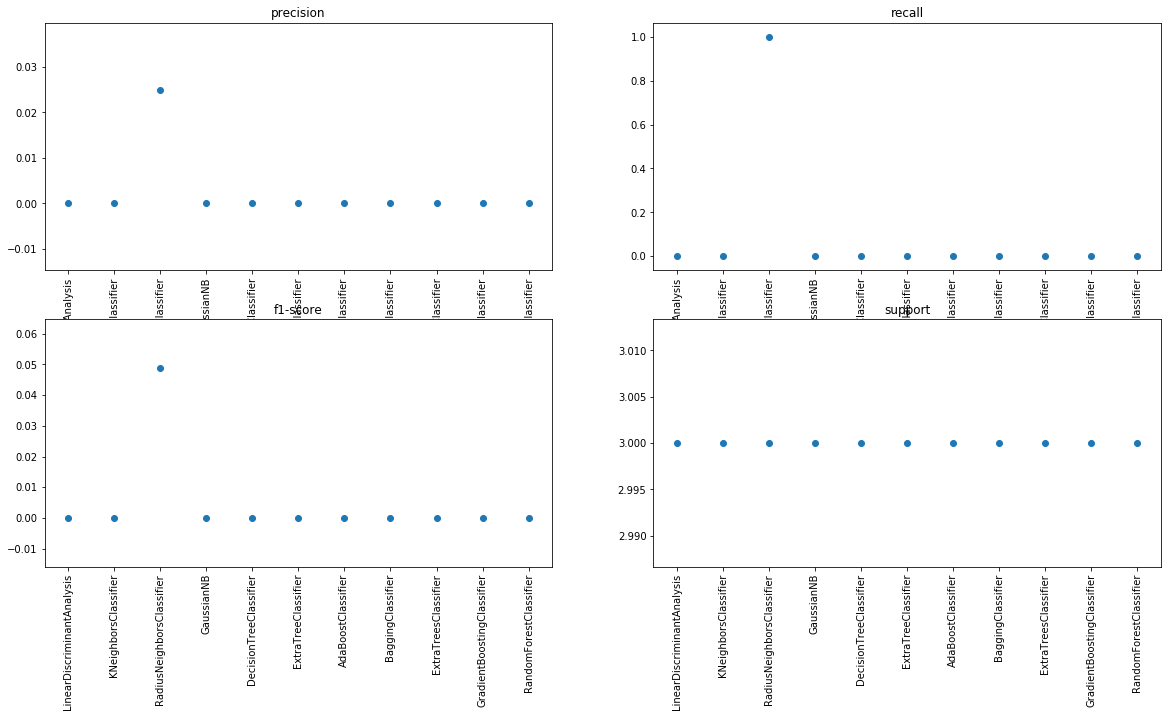

In [9]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['True']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'True')

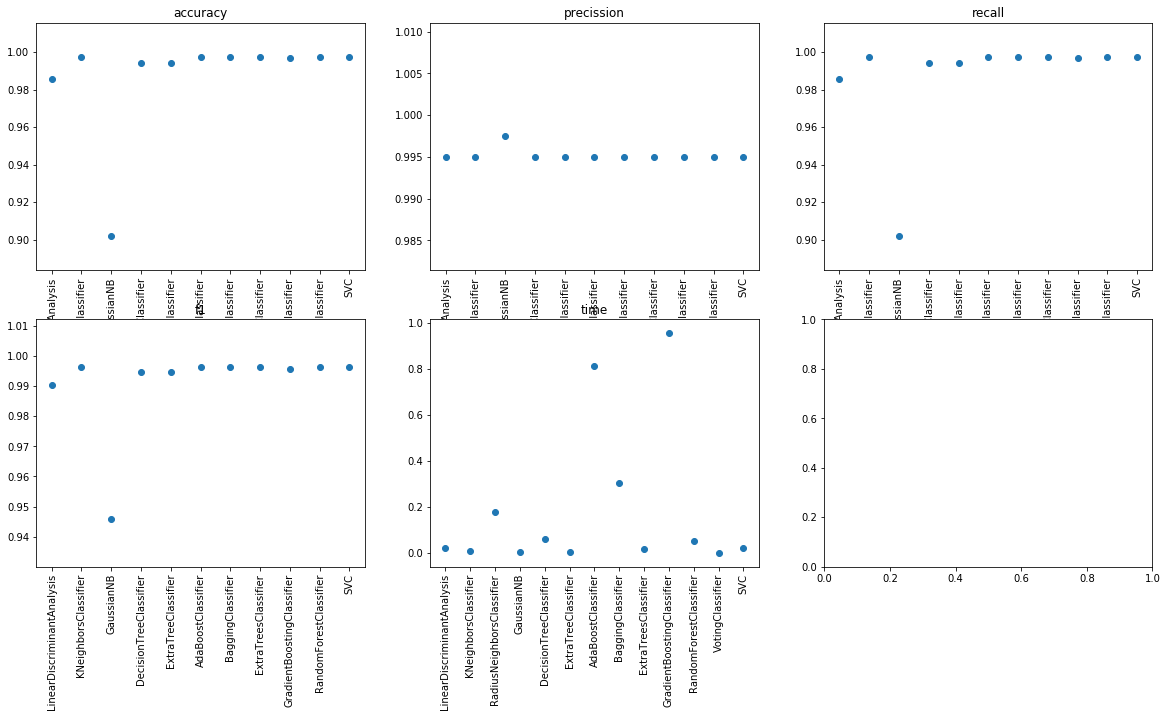

In [10]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]):
    plt.subplot(2,3,i+1)
    if metric != 'classification_report':
        plt.title(metric)
        print_metric(metric)

In [11]:
max([r['accuracy'] for _, r in results.items() if 'accuracy' in r]),\
max([r['precission'] for _, r in results.items() if 'precission' in r]),\
max([r['recall'] for _, r in results.items() if 'recall' in r]),\

(0.99748322147651, 0.9975461409395974, 0.99748322147651)

## Per Class Metrics: Belonging to Candidate or Spread

In [12]:
max([r['classification_report']['True']['precision'] for _, r in results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['True']['recall'] for _, r in results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['True']['f1-score'] for _, r in results.items() if 'False'  in r['classification_report']]),\

(0.025, 1.0, 0.04878048780487806)

## Per Class Metrics: Not belonging to Candidate or Spread

In [13]:
max([r['classification_report']['False']['precision'] for _, r in results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['False']['recall'] for _, r in results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['False']['f1-score'] for _, r in results.items() if 'False'  in r['classification_report']]),\

(1.0, 1.0, 0.998740025199496)